# Exploring logistic regression and classification error
This notebook works with PG&E's 'wire down' data to explore building a model that can predict whether or not a failure in PG&E's distribution system was caused by a third party.  

The data we'll play with come from PG&E's wildfire mitigation plan docs [here](https://www.pge.com/en_US/safety/emergency-preparedness/natural-disaster/wildfires/wildfire-mitigation-plan.page?WT.mc_id=Vanity_wildfiremitigationplan).  The wire down data are part of the "Supplemental Data Request" in the 2019-2020 docs.  The file is big, so only click [this link](https://www.pge.com/pge_global/common/pdfs/safety/emergency-preparedness/natural-disaster/wildfires/wildfire-mitigation-plan/SDR.zip) if you're ready to download 70MB!

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import re

A couple of comments on the read_csv that follows: 
* `skiprows` causes it to ignore the first $n+1$ rows
* `skipfooter` causes it to ignore the last $n$ rows
* I use `engine = 'python'` because the python parser is needed to get `skipfooter` to work properly.

In [2]:
ED_wiredown = pd.read_csv('ED_wire_down.csv', skiprows=5, skipfooter = 1000, engine = 'python')

In [3]:
ED_wiredown.columns

Index(['Division', 'District Name', 'Feeder Name', 'Feeder #', 'Device',
       'Oper #', 'Out Date', 'FNL', 'In Date', 'In\nTime', 'OIS #', 'Duration',
       'Outage Level', 'Basic Cause', 'Supplemental Cause', 'CESO', 'C Min',
       'Open Point\nLatitude', 'Open Point\nLongitude', 'Fault Location',
       'Weather', 'Failed Equipment', 'Failed Equipment\nCondition', 'Event #',
       'Const\nType', 'Sus/Mom', 'Tier'],
      dtype='object')

One case see there is a 'Basic Cause' column -- let's check that out:

In [4]:
causes = ED_wiredown['Basic Cause'].unique()
print(causes)

['3rd Party                   ' 'Animal                      '
 'Company Initiated           ' 'Environmental/External      '
 'Equipment Failure/Involved  ' 'Unknown Cause               '
 'Vegetation                  ']


In [5]:
thirdparty = np.sum(ED_wiredown['Basic Cause']==causes[0])
print('Fraction of outages that are third party is',thirdparty/len(ED_wiredown['Basic Cause']))

Fraction of outages that are third party is 0.1667156965749107


I want to use the 'Duration' column as a feature to predict whether or not the failure was caused by a third party.  

Side note: the data headers don't tell use the units for duration, but with digging into documentation you'll find the units are in minutes.

But let's look at the type on 'Duration'

In [6]:
print(ED_wiredown.loc[0:10,'Duration'])
ED_wiredown.loc[0:10,'Duration'].apply(type)

0     12,004
1      4,693
2      3,577
3      3,501
4      3,277
5      3,139
6      2,949
7      2,687
8      2,633
9      2,508
10     2,402
Name: Duration, dtype: object


0     <class 'str'>
1     <class 'str'>
2     <class 'str'>
3     <class 'str'>
4     <class 'str'>
5     <class 'str'>
6     <class 'str'>
7     <class 'str'>
8     <class 'str'>
9     <class 'str'>
10    <class 'str'>
Name: Duration, dtype: object

Those are strings!  I need to convert them to numbers.  But before doing that I need to get rid of the commas to get `pd.to_numeric` to parse correctly.  

In [7]:
for i in range(0,len(ED_wiredown)):
    ED_wiredown.loc[i,'Duration'] = re.sub(',', '', ED_wiredown.loc[i,'Duration'])   
print(ED_wiredown.loc[0:10,'Duration'])

0     12004
1      4693
2      3577
3      3501
4      3277
5      3139
6      2949
7      2687
8      2633
9      2508
10     2402
Name: Duration, dtype: object


These are still strings.  But now I can easily convert to numbers:

In [8]:
ED_wiredown['Duration'] = ED_wiredown['Duration'].apply(pd.to_numeric)

Check out the distribution of outage durations resulting from each wire down event

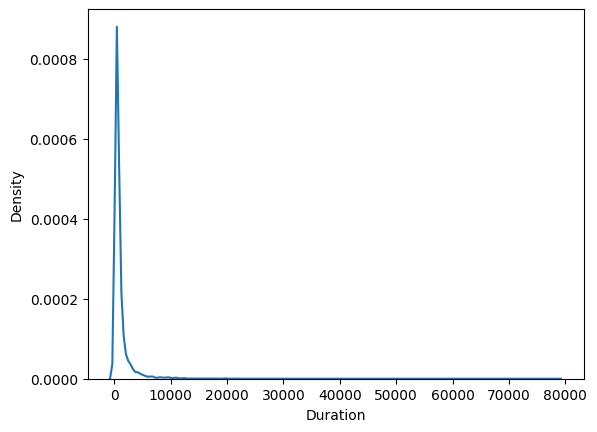

In [9]:
sns.kdeplot(ED_wiredown['Duration']);

## Classification

Ok, let's first create our classification target: is the failure cause 3rd party or not?

In [10]:
bln = ED_wiredown['Basic Cause'] == '3rd Party                   '
ED_wiredown_new = ED_wiredown
ED_wiredown_new['Coded Cause'] = bln

That just added a new column to the dataframe with a boolean (which is effectively a $0$ or $1$ variable for classification purposes) indicated whether the failure was caused by third party.  It's `True` if it was third party caused.

Now let's build a model:

In [11]:
from sklearn import linear_model

In [12]:
lgm = linear_model.LogisticRegression(fit_intercept=True, solver = 'lbfgs')

The `'lbfgs'` solver in the argument list above is the standard -- sklearn throws a warning if you don't pass that in.  It's like gradient descent, with a few bells and whistles.  

In [13]:
X = ED_wiredown_new[['Duration']]
y = ED_wiredown_new['Coded Cause']

Let's do a quick-and-dirty test-train split: Half data into test, half into train.

In [14]:
rnd = np.random.rand(len(X))
X_train = X.loc[rnd>0.5,:]
X_test = X.loc[rnd<=0.5,:]
y_train = y.loc[rnd>0.5]
y_test = y.loc[rnd<=0.5]

In [15]:
clf = lgm.fit(X_train, y_train)

Ok, model built and estimated!  Let's construct predicted values.

In [16]:
y_hat = clf.predict(X_test)

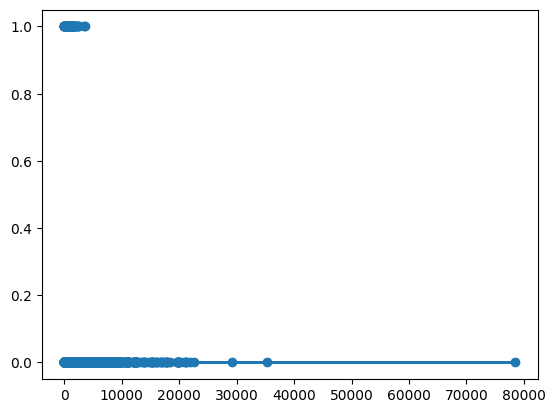

In [17]:
plt.plot(X_test,y_hat)
plt.scatter(X_test,y_test)
plt.show()

Let's plot the values versus their *probabilities* as predicted by the model.

In [18]:
y_prob = clf.predict_proba(X_test)

This produces a 2 column matrix.  The first column is the model's probability the observation is PG&E (y = 0); the second is the model's probability the observation is third party (y = 1).  So we'll plot the second column, with the expectation that the probability will be higher for cases when the observation *is* third party:

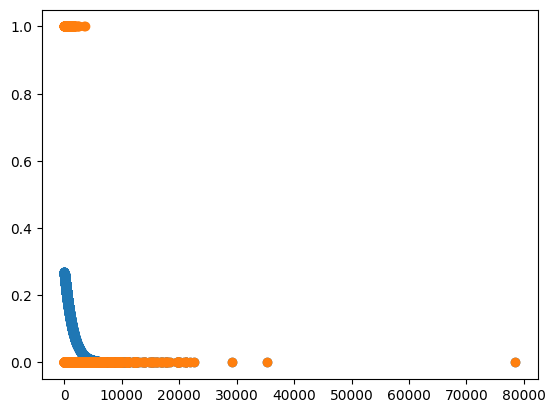

In [19]:
plt.scatter(X_test,y_prob[:,1])
plt.scatter(X_test,y_test)
plt.show()

Ok you can see from the figure that the *prediction* is that the cause is never third party.  Let's take a look at this model performance in terms of different error metrics.

In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_hat))  

[[9854    0]
 [1963    0]]


In [21]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,y_hat,target_names=['PG&E','Third Party'])) 

              precision    recall  f1-score   support

        PG&E       0.83      1.00      0.91      9854
 Third Party       0.00      0.00      0.00      1963

    accuracy                           0.83     11817
   macro avg       0.42      0.50      0.45     11817
weighted avg       0.70      0.83      0.76     11817



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SO you can see that the accuracy seems ok -- 83% -- and precision and recall for non-third party cause are high.  But when you look at the confusion matrix you can see that all of the True (i.e. caused by third party) values are getting mis-classified as false.  

Remember:
* Precision is the fraction of positives that are actually positive
* Recall is the fraction of actual positives that get identified

Side note 1: F1 score.  The F1 Score is  2*((precision * recall)/(precision + recall)). It is meant to convey the balance between the precision and the recall.  This is a way to summarize a model if you need just one measure, but it equally weights precision and recall, which obscures important "under the hood" performance.

Side note 2: avg values.  The macro avg is simply the arithmetic mean of values across classes.  The weighted avg simply weights a given metric by the number of observations in the class.

## Adding more features
Let's add the categorical variable on what equipment failed.  

In [22]:
what_failed = ED_wiredown['Failed Equipment'].unique() 
what_failed

array(['Conductor, Overhead         ', 'Pole - Tower, steel         ',
       'Pole-Wood                   ', 'Service conductor           ',
       'Connector or Splice (OH)    ', 'Crossarm, Wood              ',
       'Anchor or Guy               ', 'Secondary                   ',
       'Transformer                 ', 'Regulator                   ',
       'Insulator                   ', 'Other                       ',
       'Jumper                      ', 'Transformer (OH)            ',
       'Switch (OH)                 ', 'Woodpin                     ',
       nan, 'Cutout, fuse holder         ',
       'Booster                     ', 'Recloser                    ',
       'PGs, Kearneys               ', 'Footings, Tower or Pole     ',
       'Capacitor                   ', 'Lightning Arrestor          ',
       'Transformer (UG)            ', 'Conductor, Underground      ',
       'Cutout, Fused, Distribution ', 'Bushing                     ',
       'Crossarm, Steel          

Perhaps if one knows what failed, one can then predict who caused the failure.  First let's "one hot encode" the 'Failed equipment' variable:

In [23]:
onehots = pd.get_dummies(ED_wiredown_new['Failed Equipment'])
onehots.head()

,Anchor or Guy,Booster,Bushing,Capacitor,"Conductor, Overhead","Conductor, Underground",Connector or Splice (OH),"Crossarm, Steel","Crossarm, Wood",Customer Equipment,...,Recloser,Regulator,Secondary,Service conductor,Switch,Switch (OH),Transformer,Transformer (OH),Transformer (UG),Woodpin
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now add these one-hot encoded features to the dataframe:

In [24]:
ED_wiredown_new[onehots.columns] = onehots
ED_wiredown_new.head()

,Division,District Name,Feeder Name,Feeder #,Device,Oper #,Out Date,FNL,In Date,In\nTime,...,Recloser,Regulator,Secondary,Service conductor,Switch,Switch (OH),Transformer,Transformer (OH),Transformer (UG),Woodpin
0,NORTH VALLEY,SHASTA,GIRVAN-1101,103401101,FUSE,2073,20190212,2305,20190221,709,...,False,False,False,False,False,False,False,False,False,False
1,CENTRAL COAST,KING CITY,LOS COCHES-1102,182151102,FUSE,8883,20190628,736,20190701,1349,...,False,False,False,False,False,False,False,False,False,False
2,STOCKTON,DELTA,CHANNEL-1101,163071101,OCB,1101/2 ...,20160119,754,20160121,1931,...,False,False,False,False,False,False,False,False,False,False
3,STOCKTON,DELTA,METTLER-1110,163701110,FUSE,456647,20170217,1332,20170219,2353,...,False,False,False,False,False,False,False,False,False,False
4,HUMBOLDT,UKIAH,PHILO-1102,42601102,FUSE,5421,20180919,733,20180921,1410,...,False,False,False,False,False,False,False,False,False,False


Now let's create a new X-matrix with the duration variable (from before) and the new "what failed" variable.  

In [25]:
X_DurationCause = X.join(ED_wiredown_new.loc[:,'Anchor or Guy               ':'Woodpin                     '])  
X_DC_train = X_DurationCause.loc[rnd>0.5,:]
X_DC_test = X_DurationCause.loc[rnd<=0.5,:]

In [26]:
clf_DurationCause = lgm.fit(X_DC_train, y_train)

The gradient search did not converge.  We can fix by allowing more iterations in the gradient search (the default is 100)

In [27]:
lgm = linear_model.LogisticRegression(fit_intercept=True, solver = 'lbfgs', max_iter=200)
clf_DurationCause = lgm.fit(X_DC_train, y_train)

In [28]:
y_hat = clf_DurationCause.predict(X_DC_test)

In [29]:
print(confusion_matrix(y_test,y_hat))  
print(classification_report(y_test,y_hat,target_names=['PG&E','Third Party'])) 

[[9317  537]
 [ 846 1117]]
              precision    recall  f1-score   support

        PG&E       0.92      0.95      0.93      9854
 Third Party       0.68      0.57      0.62      1963

    accuracy                           0.88     11817
   macro avg       0.80      0.76      0.77     11817
weighted avg       0.88      0.88      0.88     11817



Interesting!  Now we are getting much better results.  Though the overall accuracy has not improved substantially, you can see now that the confusion matrix looks better -- there are more third parties getting classified as such than not.  *And* the precision and recall for PG&E's *own* failures is quite good.  

In [30]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import RocCurveDisplay

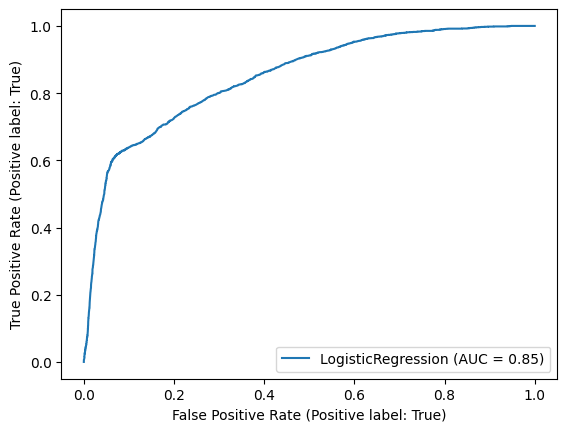

In [31]:
RocCurveDisplay.from_estimator(clf_DurationCause, X_DC_test, y_test)